GIF guardado como 'evolution.gif' en la ruta del proyecto.


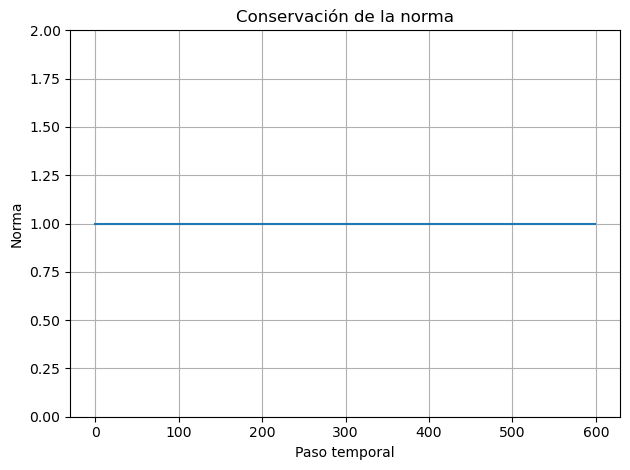

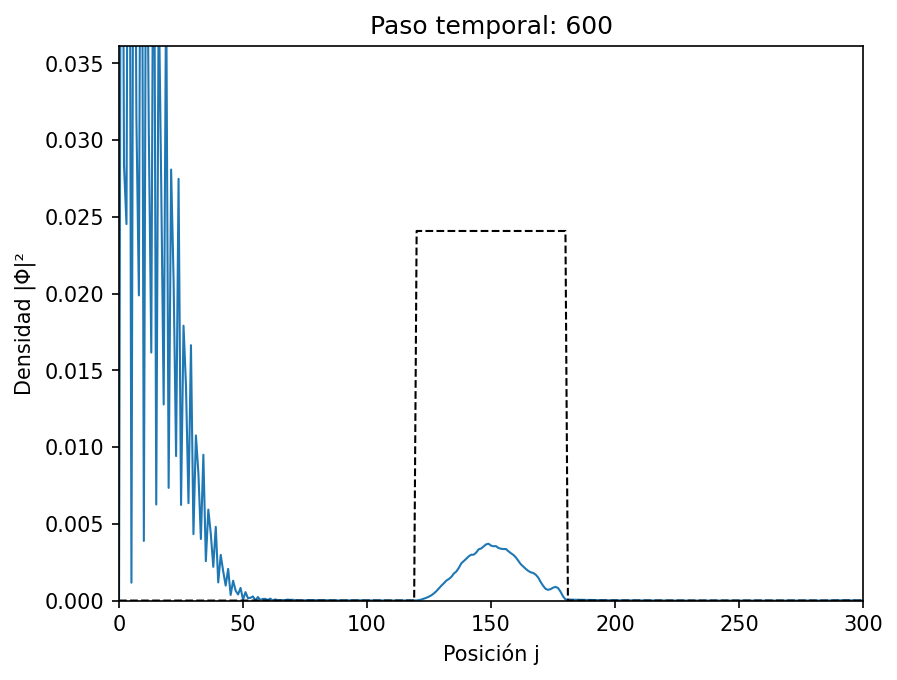

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import njit

# =============================================================
# Simulación de la ecuación de Schrödinger 1D
# Método de Crank-Nicolson (aproximación de Cayley) con animación
# =============================================================

# 1. Parámetros iniciales
def initialize_parameters(N, nciclos, lam):
    k0_tilde = 2 * np.pi * nciclos / N
    V_tilde = np.zeros(N + 1, dtype=np.float64)  # ✅ tipo explícito
    j1, j2 = int(2 * N / 5), int(3 * N / 5)
    V_tilde[j1:j2 + 1] = lam * k0_tilde ** 2
    s_tilde = 1 / (4 * k0_tilde ** 2)
    return k0_tilde, V_tilde, s_tilde

# 2. Función de onda inicial
def initialize_wave(N, k0_tilde):
    phi = np.zeros(N + 1, dtype=complex)
    j = np.arange(1, N)
    phase = np.exp(1j * k0_tilde * j)
    envelope = np.exp(-8 * (4 * j - N) ** 2 / N ** 2)
    phi[1:N] = phase * envelope
    phi[0] = phi[N] = 0  # Condiciones de frontera
    # Normalizar la función de onda
    norm = np.sqrt(np.sum(np.abs(phi)**2))
    phi /= norm
    return phi

# 3. Coeficientes alpha
@njit
def compute_alpha(N, V_tilde, s_tilde):
    alpha = np.zeros(N + 1, dtype=np.complex128)
    alpha[N - 1] = 0.0 + 0.0j
    for j in range(N - 1, 0, -1):
        A0 = -2.0 + 2.0j / s_tilde - V_tilde[j]
        gamma = 1.0 / (A0 + alpha[j])
        alpha[j - 1] = -gamma
    return alpha

# 4. Evolución temporal
@njit
def time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600):
    N = len(phi0) - 1
    phi = phi0.copy()
    phis = np.zeros((n_steps, N + 1), dtype=np.complex128)  # ✅ matriz en lugar de lista

    for n in range(n_steps):
        beta = np.zeros(N + 1, dtype=np.complex128)
        beta[N - 1] = 0.0 + 0.0j
        for j in range(N - 1, 0, -1):
            A0 = -2.0 + 2.0j / s_tilde - V_tilde[j]
            rhs = 4.0j * phi[j] / s_tilde
            beta[j - 1] = (rhs - beta[j]) / (A0 + alpha[j])

        chi = np.zeros(N + 1, dtype=np.complex128)
        for j in range(0, N):
            chi[j + 1] = alpha[j] * chi[j] + beta[j]

        phi = chi - phi
        phi /= np.sqrt(np.sum(np.abs(phi)**2))  # normalización
        phis[n] = phi  # ✅ guardamos el paso en la matriz

    return phis

# 5. Conservación de norma
def plot_norm_conservation(phis):
    norms = [np.sum(np.abs(phi)**2) for phi in phis]
    plt.figure()
    plt.plot(norms)
    plt.title('Conservación de la norma')
    plt.xlabel('Paso temporal')
    plt.ylabel('Norma')
    plt.grid(True)
    plt.ylim(0, 2)
    plt.tight_layout()


# 6. Simulación y animación
def run_simulation_and_animate(save_gif=True, gif_name='evolution.gif', plot_norm=True):
    N, nciclos, lam = 300, 60, 0.9
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    phi0 = initialize_wave(N, k0_tilde)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)

    if plot_norm:
        plot_norm_conservation(phis)

    # Preparar animación
    fig, ax = plt.subplots(dpi=150)
    x = np.arange(N + 1)
    potential_scale = np.max(np.abs(phi0)**2) / np.max(V_tilde) * 0.8 if np.max(V_tilde) > 0 else 1
    line_wave, = ax.plot([], [], lw=1)
    line_pot, = ax.plot(x, V_tilde * potential_scale, 'k--', lw=1)
    ax.set_xlim(0, N)
    ax.set_ylim(0, np.max(np.abs(phi0)**2) * 1.2)
    ax.set_xlabel('Posición j')
    ax.set_ylabel('Densidad |Φ|²')
    ax.set_title('Evolución de paquete de onda')

    def update(frame):
        phi = phis[frame]
        y = np.abs(phi)**2
        line_wave.set_data(x, y)
        ax.set_title(f'Paso temporal: {frame + 1}')
        return [line_wave]

    anim = FuncAnimation(fig, update, frames=len(phis), blit=True, interval=50)

    if save_gif:
        writer = PillowWriter(fps=20)
        anim.save(gif_name, writer=writer)
        print(f"GIF guardado como '{gif_name}' en la ruta del proyecto.")
    else:
        plt.show()

# =============================================================
# Ejecutar simulación
# =============================================================
if __name__ == '__main__':
    run_simulation_and_animate()


In [10]:
def calculate_transmission_coefficient(N=5000, nciclos=60, lam=0.1, m=100):
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    mT = 0

    for _ in range(m):
        phi0 = initialize_wave(N, k0_tilde)
        # Normalizar phi0
        phi0 /= np.sqrt(np.sum(np.abs(phi0)**2))

        phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)
        PD_t = [np.sum(np.abs(phi[4 * N // 5:]) ** 2) for phi in phis]
        nD = np.argmax(PD_t)

        phi_nD = phis[nD]
        PD_nD = np.sum(np.abs(phi_nD[4 * N // 5:]) ** 2)

        if np.random.rand() < PD_nD:
            mT += 1

    K = mT / m
    return K

print("Coeficiente de transmisión:", calculate_transmission_coefficient())

Coeficiente de transmisión: 1.0


In [ ]:
def calculate_transmission_coefficient_compare(N=500, nciclos=60, lam=0.8, m=100):
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    mT = 0
    PD_nD_list = []

    for _ in range(m):
        phi0 = initialize_wave(N, k0_tilde)
        # Normalizar phi0
        phi0 /= np.sqrt(np.sum(np.abs(phi0)**2))

        phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)
        PD_t = [np.sum(np.abs(phi[4 * N // 5:]) ** 2) for phi in phis]
        nD = np.argmax(PD_t)

        phi_nD = phis[nD]
        PD_nD = np.sum(np.abs(phi_nD[4 * N // 5:]) ** 2)
        PD_nD_list.append(PD_nD)

        if np.random.rand() < PD_nD:
            mT += 1

    K = mT / m
    PD_nD_avg = np.mean(PD_nD_list)

    print(f"Coeficiente de transmisión K (fracción de transmisiones): {K}")
    print(f"Promedio de la probabilidad pD(nD) en máximo: {PD_nD_avg}")

    return K, PD_nD_avg

print("Coeficiente de transmisión (con comparación):", calculate_transmission_coefficient_compare())
# =============================================================


Coeficiente de transmisión K (fracción de transmisiones): 0.07
Promedio de la probabilidad pD(nD) en máximo: 0.07104431450989214
Coeficiente de transmisión (con comparación): (0.07, np.float64(0.07104431450989214))


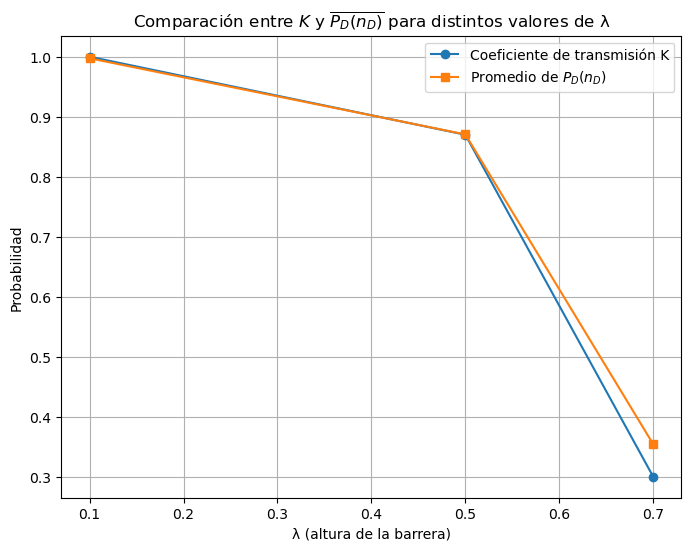

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Asegúrate de tener las funciones initialize_parameters, compute_alpha, initialize_wave, time_evolution definidas antes

def calculate_transmission_coefficient_compare(N=500, nciclos=60, lam=0.8, m=100):
    k0_tilde, V_tilde, s_tilde = initialize_parameters(N, nciclos, lam)
    alpha = compute_alpha(N, V_tilde, s_tilde)
    mT = 0
    PD_nD_list = []

    for _ in range(m):
        phi0 = initialize_wave(N, k0_tilde)
        phi0 /= np.sqrt(np.sum(np.abs(phi0)**2))  # Normalizar

        phis = time_evolution(phi0, alpha, V_tilde, s_tilde, n_steps=600)
        PD_t = [np.sum(np.abs(phi[4 * N // 5:]) ** 2) for phi in phis]
        nD = np.argmax(PD_t)

        phi_nD = phis[nD]
        PD_nD = np.sum(np.abs(phi_nD[4 * N // 5:]) ** 2)
        PD_nD_list.append(PD_nD)

        if np.random.rand() < PD_nD:
            mT += 1

    K = mT / m
    PD_nD_avg = np.mean(PD_nD_list)

    return K, PD_nD_avg

# Valores de lambda a probar
lambdas = [0.1, 0.5, 0.7]
Ks = []
PDs = []

for lam in lambdas:
    K, PD = calculate_transmission_coefficient_compare(lam=lam)
    Ks.append(K)
    PDs.append(PD)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lambdas, Ks, label='Coeficiente de transmisión K', marker='o')
plt.plot(lambdas, PDs, label='Promedio de $P_D(n_D)$', marker='s')
plt.xlabel('λ (altura de la barrera)')
plt.ylabel('Probabilidad')
plt.title('Comparación entre $K$ y $\overline{P_D(n_D)}$ para distintos valores de λ')
plt.legend()
plt.grid(True)
plt.show()


Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.93
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.96
Promedio de la probabilidad pD(nD) en máximo: 0.9298758101027499
Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.94
Promedio de la probabilidad pD(nD) en máximo: 0.9362490520528725


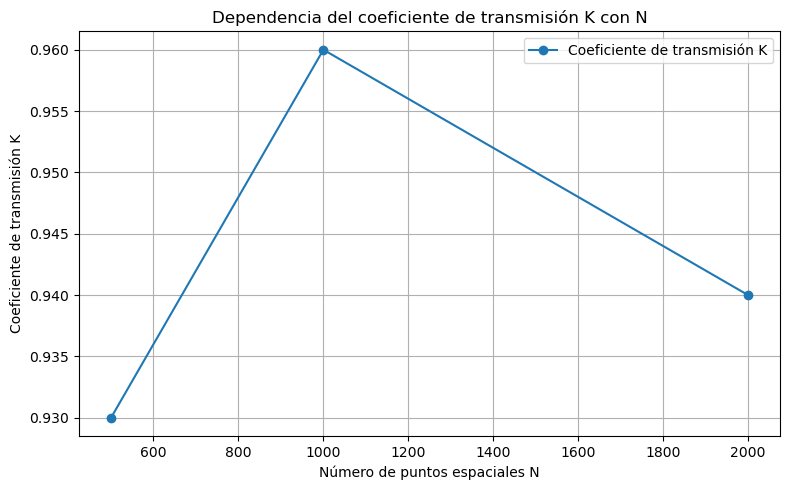

In [23]:
# =============================================================
# Estudio de la dependencia del coeficiente de transmisión K con el número de puntos espaciales N
def study_transmission_vs_N(N_values=[500, 1000, 2000], nciclos=60, lam=0.5, m=100):
    Ks = []
    for N in N_values:
        print(f"Calculando para N = {N} ...")
        K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
        Ks.append(K)

    plt.figure(figsize=(8,5))
    plt.plot(N_values, Ks, 'o-', label='Coeficiente de transmisión K')
    plt.xlabel('Número de puntos espaciales N')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia del coeficiente de transmisión K con N')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejemplo de ejecución
if __name__ == '__main__':
    study_transmission_vs_N()


Estudiando para λ = 0.5
  Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.85
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
  Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.94
Promedio de la probabilidad pD(nD) en máximo: 0.9298758101027499
  Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.93
Promedio de la probabilidad pD(nD) en máximo: 0.9362490520528725
Estudiando para λ = 0.7
  Calculando para N = 500 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.35
Promedio de la probabilidad pD(nD) en máximo: 0.3541818186288528
  Calculando para N = 1000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.57
Promedio de la probabilidad pD(nD) en máximo: 0.6291698634577433
  Calculando para N = 2000 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.57
Promedio de la probabilidad pD(nD) en máximo: 0.6845794388468347


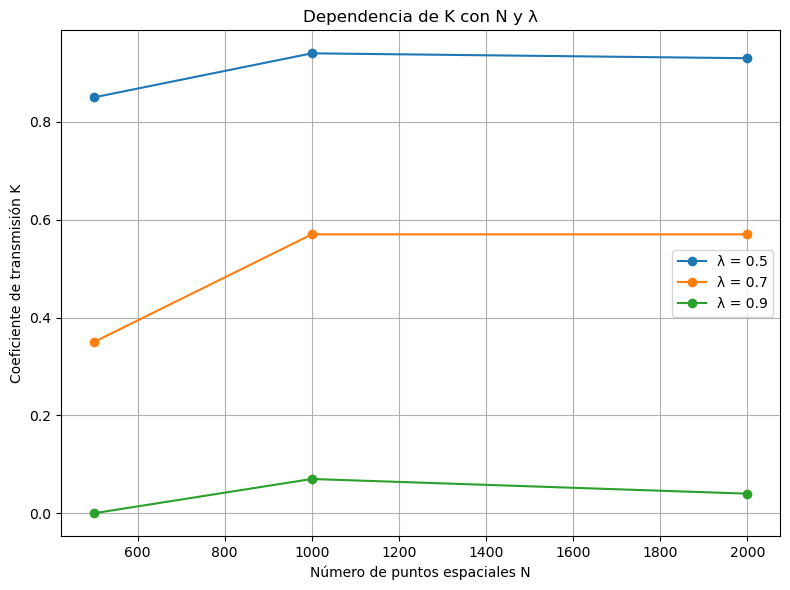

In [24]:
import matplotlib.pyplot as plt

def study_transmission_vs_N_and_lambda(N_values=[500, 1000, 2000], lam_values=[0.5, 0.7, 0.9], nciclos=60, m=100):
    plt.figure(figsize=(8,6))

    for lam in lam_values:
        Ks = []
        print(f"Estudiando para λ = {lam}")
        for N in N_values:
            print(f"  Calculando para N = {N} ...")
            K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
            Ks.append(K)
        plt.plot(N_values, Ks, 'o-', label=f'λ = {lam}')

    plt.xlabel('Número de puntos espaciales N')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con N y λ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejemplo de ejecución
if __name__ == '__main__':
    study_transmission_vs_N_and_lambda()


In [ ]:
# Comentario sobre el gráfico obtenido
"""


En resumen, los resultados obtenidos en el gráfico son consistentes con las predicciones teóricas de la mecánica cuántica y demuestran cómo el efecto túnel depende tanto de las características 
de la barrera de potencial como de la resolución espacial utilizada en laEn el gráfico superior, se observa cómo varía el coeficiente de transmisión K en función del número de puntos espaciales N para diferentes valores de la altura de la barrera λ. 
Para cada valor de λ, el coeficiente de transmisión K muestra una tendencia específica que refleja la interacción entre la resolución espacial y la altura de la barrera.

A medida que aumenta N, la resolución espacial mejora, lo que permite una representación más precisa de la barrera de potencial y de la función de onda. 
Esto puede influir en el cálculo del coeficiente de transmisión, especialmente para valores altos de λ, donde la barrera es más difícil de atravesar.

Además, se observa que para valores más altos de λ, el coeficiente de transmisión K es menor, lo cual es consistente con la teoría de túnel cuántico. 
Barreras más altas reducen la probabilidad de que la partícula atraviese la barrera, disminuyendo así la transmisión.

# Explicación teórica
La ecuación de Schrödinger describe el comportamiento de partículas cuánticas y permite estudiar el fenómeno de túnel cuántico. 
Cuando una partícula se enfrenta a una barrera de potencial, existe una probabilidad finita de que atraviese la barrera, incluso si su energía es menor que la altura de la barrera. 
Este fenómeno, conocido como efecto túnel, es una consecuencia directa de la naturaleza ondulatoria de las partículas en mecánica cuántica.

El coeficiente de transmisión K representa la fracción de partículas que logran atravesar la barrera. Según la teoría, K depende de parámetros como la altura de la barrera λ, 
el ancho de la barrera y la energía de la partícula. Barreras más altas o más anchas tienden a reducir K, ya que la probabilidad de túnel disminuye.

En el gráfico, la dependencia de K con N también refleja cómo la resolución espacial afecta la simulación. Un mayor número de puntos espaciales N permite una representación más precisa 
de la barrera y de la función de onda, lo que puede influir en los resultados obtenidos. simulación.
"""

Estudiando la dependencia de K con λ:
  Calculando para λ = 0.1 ...
Coeficiente de transmisión K (fracción de transmisiones): 1.0
Promedio de la probabilidad pD(nD) en máximo: 0.9973856821070559
  Calculando para λ = 0.3 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.96
Promedio de la probabilidad pD(nD) en máximo: 0.9733261478989584
  Calculando para λ = 0.5 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.89
Promedio de la probabilidad pD(nD) en máximo: 0.8705259492145687
  Calculando para λ = 1 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.0
Promedio de la probabilidad pD(nD) en máximo: 0.0003658137143745913
  Calculando para λ = 5 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.0
Promedio de la probabilidad pD(nD) en máximo: 0.0001435133044115767
  Calculando para λ = 10 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.0
Promedio de la probabilidad pD(nD) en máximo: 1.0811286329074726e-15


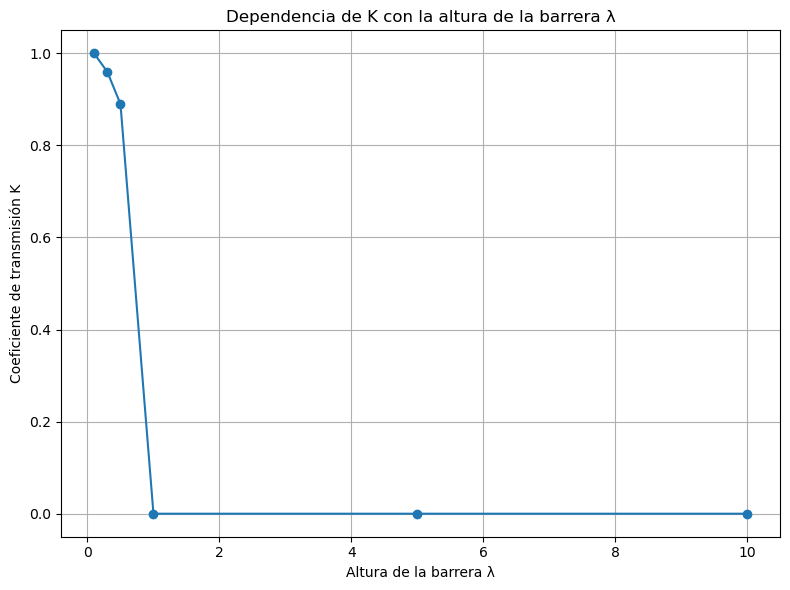

In [26]:
def study_transmission_vs_lambda(lam_values=[0.1, 0.3, 0.5, 1, 5, 10], N=500, nciclos=60, m=100):
    """
    Estudia cómo varía el coeficiente de transmisión K en función del parámetro λ (altura de la barrera).
    """
    Ks = []
    print("Estudiando la dependencia de K con λ:")
    for lam in lam_values:
        print(f"  Calculando para λ = {lam} ...")
        K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
        Ks.append(K)

    # Graficar resultados
    plt.figure(figsize=(8,6))
    plt.plot(lam_values, Ks, 'o-', color='tab:blue')
    plt.xlabel('Altura de la barrera λ')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con la altura de la barrera λ')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejecutar
if __name__ == '__main__':
    study_transmission_vs_lambda()


Estudiando la dependencia de K con λ (incluyendo λ = 0.1):
  Calculando para λ = 0.100 ...
Coeficiente de transmisión K (fracción de transmisiones): 1.0
Promedio de la probabilidad pD(nD) en máximo: 0.9973856821070559
  Calculando para λ = 0.300 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.98
Promedio de la probabilidad pD(nD) en máximo: 0.9733261478989584
  Calculando para λ = 0.337 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.98
Promedio de la probabilidad pD(nD) en máximo: 0.9639931342235876
  Calculando para λ = 0.374 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.96
Promedio de la probabilidad pD(nD) en máximo: 0.9519188164707232
  Calculando para λ = 0.411 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.94
Promedio de la probabilidad pD(nD) en máximo: 0.9362378765202289
  Calculando para λ = 0.447 ...
Coeficiente de transmisión K (fracción de transmisiones): 0.93
Promedio de la probabilidad pD(nD) en máximo: 0

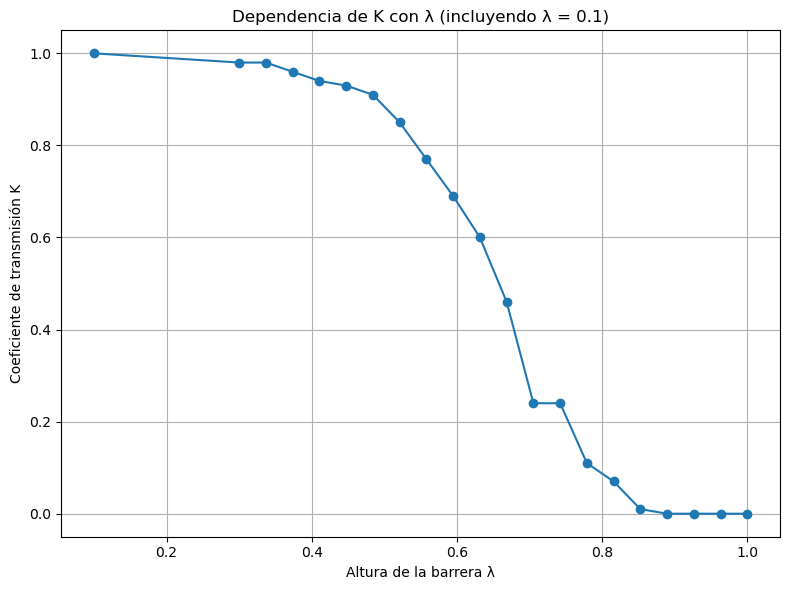

In [28]:
def study_transmission_vs_lambda_fine_with_low_point(N=500, nciclos=60, m=100):
    """
    Estudia cómo varía el coeficiente de transmisión K en función de λ,
    incluyendo λ = 0.1 y un rango denso entre 0.3 y 1.0.
    """
    # Valores de lambda: 0.1 + 20 valores entre 0.3 y 1.0
    lambda_range = np.linspace(0.3, 1.0, 20)
    lam_values = np.concatenate(([0.1], lambda_range))

    Ks = []

    print("Estudiando la dependencia de K con λ (incluyendo λ = 0.1):")
    for lam in lam_values:
        print(f"  Calculando para λ = {lam:.3f} ...")
        K, PD_nD_avg = calculate_transmission_coefficient_compare(N=N, nciclos=nciclos, lam=lam, m=m)
        Ks.append(K)

    # Graficar
    plt.figure(figsize=(8,6))
    plt.plot(lam_values, Ks, 'o-', color='tab:blue')
    plt.xlabel('Altura de la barrera λ')
    plt.ylabel('Coeficiente de transmisión K')
    plt.title('Dependencia de K con λ (incluyendo λ = 0.1)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejecutar análisis
if __name__ == '__main__':
    study_transmission_vs_lambda_fine_with_low_point()
